In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pickle
from skimage import measure, segmentation, feature
from vis_utils import load_volume, VolumeVisualizer, ColorMapVisualizer
from scipy.ndimage import zoom
from scipy.signal import fftconvolve
from skimage.morphology import skeletonize_3d, binary_dilation, convex_hull_image
from skimage import filters, morphology
from scipy import signal
from skimage.filters import frangi, sato
from PIL import Image
from tqdm import tqdm

from scipy.ndimage import zoom

In [2]:
TREE_NAME = 'P13'

## Loading specimen volume

In [4]:
source_dir = './data'
files = {path.split('\\')[1]: path for path in sorted(glob.glob(source_dir + '*/*.mhd') + sorted(glob.glob(source_dir + '*/*.raw')))}
files

{}

In [3]:
%%time
#volume = load_volume(files[TREE_NAME])
volume = load_volume('../data/P13/data.raw')
print(volume.shape)
# VolumeVisualizer(volume, binary=False).visualize()

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "../data/P13/data.mhd" does not exist.

In [5]:
# good_names = list({
#     'P01': 21,    'P02': 28,    'P03': 160,    'P04': 30,
#     'P05': 24,    'P06': 22,    'P07': 100,    'P09': 70,
#     'P10': 50,    'P11': 50,    'P12': 74,    'P13': 45,
#     'P14': 42,    'P15': 95,    'P16': 25,    'P17': 80,
#     'P18': 85,    'P19': 50,    'P20': 95,    'P21': 45,
#     'P23': 60,    'P24': 80,    'P25': 70,    'P26': 130,
#     'P27': 70,    'P28': 25,    'P30': 80,    'P31': 50,
#     'P32': 48,    'P33': 65,}.keys())
# # good_names

In [6]:
 reko = np.load('reconstruction.npy')

In [6]:
# for name in good_names:
# #     reko = np.load(source_dir + name + '/reconstruction.npy')
# #     central_line = np.load(source_dir + name + '/central-line.npy')
#     print(name)
#     volume = load_volume(files[name])
#     mask = volume > thresholds[name]
#     # volume = None
#     visualize_mask_bin(mask)

In [5]:
if files[TREE_NAME][-3:] == "mhd":
    v2 = 255 * (volume.astype(np.float64) / volume.max())
    v2 = v2.astype(np.uint8)
    VolumeVisualizer(v2, binary=False).visualize() 
    v2.shape
    v2.tofile(files[TREE_NAME][:-4] + f'_60um_{v2.shape[2]}x{v2.shape[1]}x{v2.shape[0]}.raw')

In [3]:
v2 = np.fromfile('../data/P13/data.raw', dtype=np.uint8)

In [4]:
v2.shape

(484468832,)

In [5]:
v2 = v2.reshape( 877,  488, 1132,)

In [6]:
v2 = v2[200:700, :, 100:650]
val = 20

v2[:, 200:, -35:] = val
v2[-150:, 200:, -100:-35] = val
v2[:, -200:-150, -100:-35] = val
v2[:, :210, -50:] = val
v2[:150, :150, -85:-50] = val

v2 = v2[-170:-40,200:480,30:260]
v2[-90:, :, -110:] = val
v2[:, -80:, -92:] = val

In [7]:
v2.shape

(130, 280, 230)

In [7]:
VolumeVisualizer(v2, binary=False).visualize() 

## Utility visualisation functions

In [8]:
def visualize_addition(base, base_with_addition):
    base = (base.copy() > 0).astype(np.uint8)
    addition = (base_with_addition > 0).astype(np.uint8)
    addition[base == 1] = 0
    ColorMapVisualizer(base + addition * 4).visualize()
    
def visualize_lsd(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize()
    
def visualize_gradient(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize(gradient=True)
    
def visualize_mask_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8), binary=True).visualize()
    
def visualize_mask_non_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8) * 255, binary=False).visualize()
    
def visualize_skeleton(mask, visualize_mask=True, visualize_both_versions=False):
    skeleton = skeletonize_3d((mask > 0).astype(np.uint8))
    if not visualize_mask or visualize_both_versions:
        VolumeVisualizer(skeleton, binary=True).visualize()
    if visualize_mask or visualize_both_versions:
        skeleton = skeleton.astype(np.uint8) * 4
        mask = (mask > 0).astype(np.uint8) * 3
        mask[skeleton != 0] = 0
        ColorMapVisualizer(skeleton + mask).visualize()

def visualize_ultimate(lsd, base_mask):
    visualize_lsd(lsd)
    visualize_mask_non_bin(lsd)
    visualize_addition(base_mask, lsd)
    visualize_skeleton(lsd, visualize_mask=True)

## Thresholding volume to get binary mask

In [21]:
VolumeVisualizer(volume, binary=False).visualize() 

In [9]:
thresholds = {
    'P01': 21,
    'P02': 28,
    'P03': 160,
    'P04': 30,
    'P05': 24,
    'P06': 22,
    'P07': 100,
    'P08': 38,#"Not usable",
    'P09': 70,
    'P10': 50,
    'P11': 50,
    'P12': 74,
    'P13': 45,
    'P14': 42,
    'P15': 95,
    'P16': 25,
    'P17': 80,
    'P18': 85,
    'P19': 50,
    'P20': 95,
    'P21': 45,
    'P22': 40,#"Weird artefact",
    'P23': 60,
    'P24': 80,
    'P25': 70,
    'P26': 130,
    'P27': 70,
    'P28': 25,
    
    'P29': 120, #TODO for now seems unusable, too clutered
    'P30': 80,
    'P31': 50,
    'P32': 48,
    'P33': 65,
}

mask = v2 > thresholds[TREE_NAME]
# volume = None
visualize_mask_bin(mask)

In [22]:
visualize_mask_bin(mask[:-40, :, :])

In [21]:
visualize_mask_non_bin(mask)

In [13]:
%%time
skeleton = (skeletonize_3d(mask) > 0).astype(np.uint8)

CPU times: user 361 ms, sys: 12.6 ms, total: 374 ms
Wall time: 538 ms


In [14]:
visualize_mask_bin(skeleton)

## Extracting main region 

In [10]:
def get_main_regions(binary_mask, min_size=10_000, connectivity=3):
    labeled = measure.label(binary_mask, connectivity=connectivity)
    region_props = measure.regionprops(labeled)
    
    main_regions = np.zeros(binary_mask.shape)
    bounding_boxes = []
    for props in region_props:
        if props.area >= min_size:
            bounding_boxes.append(props.bbox)
            main_regions = np.logical_or(main_regions, labeled==props.label)
            
    lower_bounds = np.min(bounding_boxes, axis=0)[:3]
    upper_bounds = np.max(bounding_boxes, axis=0)[3:]

    return main_regions[
        lower_bounds[0]:upper_bounds[0],
        lower_bounds[1]:upper_bounds[1],
        lower_bounds[2]:upper_bounds[2],
    ], bounding_boxes

In [11]:
main_region_min_size = {
    'P01': 30_000,
    'P03': 50_000,
    'P07': 300_000,
    'P17': 300_000,

}

main_regions, bounding_boxes = get_main_regions(mask, min_size=main_region_min_size.get(TREE_NAME, 20_000))
print('number of main regions:', len(bounding_boxes))
mask_main = main_regions
# mask = None
visualize_mask_non_bin(mask_main)

number of main regions: 1


In [25]:
visualize_mask_non_bin(mask_main[:-70, :, :])

# Creating reconstruction using resolution scaling

In [12]:
def f(mask, scale, order=0):
    return zoom(mask, scale, order=order)
    
def verify_mask(mask):
    regions_count = np.max(measure.label(mask, connectivity=3))
    print("one-piece mask" if regions_count == 1 else f"scattered mask, number of regions: {regions_count}")

### Creating reconstruction of scaled tree

In [27]:
%%time
scales = {
    'P01': 0.5,
    'P02': 0.7,
    'P06': 0.8,
    'P09': 0.8,
    'P11': 0.7,
    'P13': 0.8,
    'P17': 0.8,
    'P27': 0.8,
    'P28': 0.8
}
s_main_region_min_size = {
    'P01': 10_000,
    'P17': 50_000,
}

s_volume = load_volume(files[TREE_NAME], scale=scales.get(TREE_NAME, 0.5))
print('scaled volume shape', s_volume.shape)
s_mask = s_volume > thresholds[TREE_NAME]
s_volume = None
s_main_regions, s_bounding_boxes = get_main_regions(s_mask, min_size=s_main_region_min_size.get(TREE_NAME, 10_000))
print('number of s main regions:', len(s_bounding_boxes))
s_mask_main = s_main_regions
s_mask = None
s_main_regions = None
verify_mask(s_mask_main)

NameError: name 'files' is not defined

In [23]:
visualize_mask_non_bin(s_mask_main)

In [13]:
def spherical_kernel(outer_radius, thickness=1, filled=True):    
    outer_sphere = morphology.ball(radius=outer_radius)
    if filled:
        return outer_sphere
    
    thickness = min(thickness, outer_radius)
    
    inner_radius = outer_radius - thickness
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere

def convolve_with_ball(img, ball_radius, dtype=np.uint16, normalize=True, fft=True):
    kernel = spherical_kernel(ball_radius, filled=True)
    if fft:
        convolved = fftconvolve(img.astype(dtype), kernel.astype(dtype), mode='same')
    else:
        convolved = signal.convolve(img.astype(dtype), kernel.astype(dtype), mode='same')
    
    if not normalize:
        return convolved
    
    return (convolved / kernel.sum()).astype(np.float16)

def calculate_reconstruction(mask, kernel_sizes=[10, 9, 8], fill_threshold=0.5, iters=1, conv_dtype=np.uint16, fft=True):
    kernel_sizes_maps = []
    mask = mask.astype(np.uint8)
    
    for i in range(iters):
        kernel_size_map = np.zeros(mask.shape, dtype=np.uint8)

        for kernel_size in kernel_sizes:
            fill_percentage = convolve_with_ball(mask, kernel_size, dtype=conv_dtype, normalize=True, fft=fft)
            
            above_threshold_fill_indices = fill_percentage > fill_threshold
            kernel_size_map[above_threshold_fill_indices] = kernel_size + 1

            mask[above_threshold_fill_indices] = 1
            
            print(f'Iteration {i + 1} kernel {kernel_size} done')

        kernel_sizes_maps.append(kernel_size_map)
        print(f'Iteration {i + 1} ended successfully')

    return kernel_sizes_maps

In [ ]:
#PSEUDO
def calculate_reconstruction(volume, iterations):
    reconstructed_volume = volume.copy()
    for i in range(iterations):
        for kernel_radius in range(1, 26):
            fill_percentage = convolve_with_ball(volume, kernel_radius)
            above_fill_threshold_mask = fill_percentage > 0.5
            reconstructed_volume[above_fill_threshold_mask] = 1
    return reconstructed_volume

In [14]:
%%time

s_kernel_sizes = {
    'P01': range(0, 14),
    'P02': range(0, 14),
#     'P03': range(0, 13),
#     'P04': range(0, 13),
#     'P05': range(0, 13),
#     'P06': range(0, 13),
    'P07': range(0, 14),
    'P09': range(0, 12),
    'P10': range(0, 12),
#     'P11': range(0, 13),
#     'P12': range(0, 13),
    'P13': range(0, 16),
#     'P14': range(0, 13),
    'P15': range(0, 14),
#     'P16': range(0, 13),
    'P17': range(0, 14),
#     'P18': range(0, 13),
    'P19': range(0, 12),
#     'P20': range(0, 13),
    'P21': range(0, 12),
    'P23': range(0, 14),
#     'P24': range(0, 13),
#     'P25': range(0, 13),
#     'P26': range(0, 13),
#     'P27': range(0, 13)
    'P28': range(0, 14),
}

s_number_of_iterations = {
    'P01': 7,
    'P02': 1,
    'P03': 10,
    'P04': 2,
    'P05': 3,
    'P06': 5,
    'P07': 4,
    'P09': 6,
    'P10': 5,
    'P11': 4, 
    'P12': 3,
    'P13': 3,
    'P14': 2,
    'P15': 3,
    'P16': 5,
    'P17': 10,
    'P18': 4,
    'P19': 2,
    'P20': 1,
    'P21': 3,
    'P23': 5,
    'P24': 2,
    'P25': 6,
    'P26': 6,
    'P27': 1,
    'P28': 1,
    'P30': 1,
    'P31': 3,
    'P32': 3,
    'P33': 3,
}

s_recos = calculate_reconstruction(mask_main, 
                                   kernel_sizes=s_kernel_sizes.get(TREE_NAME, range(0, 13)), 
                                   iters=s_number_of_iterations.get(TREE_NAME, 3))

Iteration 1 kernel 0 done
Iteration 1 kernel 1 done
Iteration 1 kernel 2 done
Iteration 1 kernel 3 done
Iteration 1 kernel 4 done
Iteration 1 kernel 5 done
Iteration 1 kernel 6 done
Iteration 1 kernel 7 done
Iteration 1 kernel 8 done
Iteration 1 kernel 9 done
Iteration 1 kernel 10 done
Iteration 1 kernel 11 done
Iteration 1 kernel 12 done
Iteration 1 kernel 13 done
Iteration 1 kernel 14 done
Iteration 1 kernel 15 done
Iteration 1 ended successfully
Iteration 2 kernel 0 done
Iteration 2 kernel 1 done
Iteration 2 kernel 2 done
Iteration 2 kernel 3 done
Iteration 2 kernel 4 done
Iteration 2 kernel 5 done
Iteration 2 kernel 6 done
Iteration 2 kernel 7 done
Iteration 2 kernel 8 done
Iteration 2 kernel 9 done
Iteration 2 kernel 10 done
Iteration 2 kernel 11 done
Iteration 2 kernel 12 done
Iteration 2 kernel 13 done
Iteration 2 kernel 14 done
Iteration 2 kernel 15 done
Iteration 2 ended successfully
Iteration 3 kernel 0 done
Iteration 3 kernel 1 done
Iteration 3 kernel 2 done
Iteration 3 kern

In [15]:
visualize_mask_non_bin(s_recos[-1])

In [26]:
# s_recos = np.load(source_dir + TREE_NAME + '/scaled_recos.npy')

(3.0, 0.0)

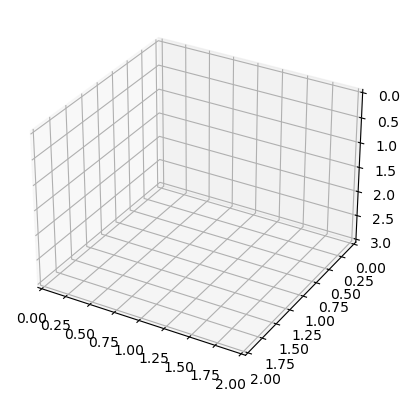

In [19]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

data = np.load('reconstruction.npy')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


max_range = np.array([data.max(axis=0), data.min(axis=0)]).max(axis=0)
ax.set_xlim(max(max_range[0]), max(max_range[1]))
ax.set_ylim(max(max_range[1]), max(max_range[0]))
ax.set_zlim(max(max_range[2]), max(max_range[0]))

In [16]:
s_reco = s_recos[-1] > 0

In [21]:
np.save('../data/P13/reco', np.array(s_reco))
# s_recos = np.load(source_dir + TREE_NAME + '/scaled_recos.npy')

In [22]:
np.save('../data/P13/original', np.array(mask_main))

### Scaled reco verification

In [43]:
visualize_mask_non_bin(reko)

NameError: name 'reko' is not defined

In [44]:
visualize_skeleton(s_recos[1])

In [46]:
visualize_addition(mask_main, s_reco)

In [47]:
verify_mask(s_reco)

one-piece mask


### Scaling up and trimming reconstruction of scaled tree

In [33]:
def upscale_reconstruction(s_reco, scale):
    upscale = 1 / scale
    u_reco = scale_mask(s_reco, upscale, order=3)
    return u_reco

In [34]:
%%time
u_reco = upscale_reconstruction(s_reco, scale=scales.get(TREE_NAME, 0.5))

Wall time: 2min 58s


In [35]:
shape = np.min([mask_main.shape, u_reco.shape], axis=0)
print('mask_main shape', mask_main.shape, 'u_reco shape', u_reco.shape)
print('final shape', shape)
mask_main_r = mask_main[:shape[0], :shape[1], :shape[2]]
u_reco_r = u_reco[:shape[0], :shape[1], :shape[2]]

mask_main shape (943, 486, 1443) u_reco shape (929, 485, 1442)
final shape [ 929  485 1442]


In [36]:
u_reco_r = u_reco[:shape[0], :shape[1], 14:]
u_reco_r.shape

# mask_main_r = mask_main[:shape[0], :shape[1], 14:]
# mask_main_r.shape

(929, 485, 1428)

In [37]:
joint_reco = np.logical_or(mask_main_r, u_reco_r)
verify_mask(joint_reco)
main_regions, bounding_boxes = get_main_regions(joint_reco, min_size=main_region_min_size.get(TREE_NAME, 20_000))
print('number of main regions:', len(bounding_boxes))
new_joint_reco = np.logical_or(mask_main_r, main_regions)
# visualize_addition(mask_main_r, new_joint_reco)

ValueError: operands could not be broadcast together with shapes (929,485,1442) (929,485,1428) 

In [ ]:
np.sum(joint_reco), np.sum(main_regions), np.sum(new_joint_reco)

In [ ]:
visualize_addition(mask_main_r, new_joint_reco)

### Fine tuning full res reconstruction

In [37]:
%%time

ft_kernel_sizes = {
    'P01': range(0, 28),
    'P02': range(0, 28),
#     'P03': range(0, 26),
#     'P04': range(0, 26),
#     'P05': range(0, 26),
#     'P06': range(0, 26),
#     'P07': range(0, 26),
    'P09': range(0, 24),
    'P10': range(0, 24),
#     'P11': range(0, 26),
#     'P12': range(0, 26),
#     'P13': range(0, 26),
#     'P14': range(0, 26),
    'P15': range(0, 24),
    'P16': range(0, 24),
    'P17': range(0, 25),
#     'P18': range(0, 26),
    'P19': range(0, 24),
#     'P20': range(0, 26),
    'P21': range(0, 24),
    'P23': range(0, 28),
#     'P24': range(0, 26),
#     'P25': range(0, 26),
#     'P26': range(0, 26),
#     'P27': range(0, 26),
    'P28': range(0, 15),
}

ft_number_of_iterations = {
    'P01': 1,
    'P19': 2,
    'P20': 2,
    'P30': 3,
    'P31': 2,
    'P33': 2,
}

ft_recos = calculate_reconstruction(new_joint_reco, 
                                    kernel_sizes=ft_kernel_sizes.get(TREE_NAME, range(0, 26)), 
                                    iters=ft_number_of_iterations.get(TREE_NAME, 1))

Iteration 1 kernel 0 done
Iteration 1 kernel 1 done
Iteration 1 kernel 2 done
Iteration 1 kernel 3 done
Iteration 1 kernel 4 done
Iteration 1 kernel 5 done
Iteration 1 kernel 6 done
Iteration 1 kernel 7 done
Iteration 1 kernel 8 done
Iteration 1 kernel 9 done
Iteration 1 kernel 10 done
Iteration 1 kernel 11 done
Iteration 1 kernel 12 done
Iteration 1 kernel 13 done
Iteration 1 kernel 14 done
Iteration 1 kernel 15 done
Iteration 1 kernel 16 done
Iteration 1 kernel 17 done
Iteration 1 kernel 18 done
Iteration 1 kernel 19 done
Iteration 1 kernel 20 done
Iteration 1 kernel 21 done
Iteration 1 kernel 22 done
Iteration 1 kernel 23 done
Iteration 1 kernel 24 done
Iteration 1 kernel 25 done
Iteration 1 ended successfully
Wall time: 42min 48s


In [38]:
reco = ft_recos[-1]

## Verify and save reconstruction

In [40]:
visualize_mask_non_bin(reco)
visualize_skeleton(reco)
visualize_addition(mask_main_r, reco) 

In [39]:
padded_reco = np.pad(reco, 1) # padding reconstruction to avoid padding later
np.save(source_dir + TREE_NAME + '/reconstruction', padded_reco)

## Verifying obtained reconstruction 

In [ ]:
# if the reconstruction looks bad try using results of previous iterations
# if the skelecon still has mistletoes try increasing number of iterations
reconstruction = (lsd_trees[-1] > 0).astype(np.uint8)
visualize_mask_non_bin(reconstruction) # check for holes
visualize_skeleton(reconstruction) # check for mistletoes
visualize_addition(mask_main, reconstruction) # check for anomalies